In [47]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../scripts/')

import os
os.environ["PATH"] += os.pathsep + r'\Users\Mattia\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x64'
print(os.getenv("PATH"))

from proj1_helpers import *
from implementations import *
from implementation_variants import *
from plots import *

SEED = 42
DATA_PATH = '../data/'

C:\Users\Mattia\anaconda3;C:\Users\Mattia\anaconda3\Library\mingw-w64\bin;C:\Users\Mattia\anaconda3\Library\usr\bin;C:\Users\Mattia\anaconda3\Library\bin;C:\Users\Mattia\anaconda3\Scripts;C:\Users\Mattia\anaconda3\bin;C:\Users\Mattia\anaconda3\condabin;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files\MATLAB\R2020a\bin;C:\Program Files\Git\cmd;C:\Program Files\Git\mingw64\bin;C:\Program Files\Git\usr\bin;C:\Users\Mattia\AppData\Local\Microsoft\WindowsApps;C:\Users\Mattia\AppData\Local\GitHubDesktop\bin;C:\Users\Mattia\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x64;\Users\Mattia\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x64;\Users\Mattia\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x64;\Users\Mattia\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x64;\Users\Mattia\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x64;\Users\Mattia\AppData\Local\Programs\MiKTeX 2.9\miktex\bin\x64


# 0 Load data

In [49]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train.set_index('Id')
df_train_x = df_train[list(filter(lambda c: c != 'Prediction', list(df_train)))]

FEATURE_NAMES = list(df_train_x)
FEATURE_NAMES=FEATURE_NAMES+[str(i) for i in range(180-len(FEATURE_NAMES))]

 # Load train data
y, x, ids = load_csv_data(path.join(DATA_PATH, 'train.csv'))

In [50]:
for i in range(30):
    meani=x[:,i][x[:,i] != -999.0].mean()
    x[:,i][x[:,i] == -999.0]=meani

In [51]:
x=np.hstack((x,x**2,x**3,x**4,x**5,x**6))

# Split into train and evaluation set
(x_train, y_train), (x_eval, y_eval) = train_eval_split(y, x, split_ratio=.7, seed=1) #alternatives: CV or adding validation and testing

print(f' # train samples: {len(y_train)}\n # eval samples: {len(y_eval)}')

num_dim = x_train.shape[1]

 # train samples: 175000
 # eval samples: 75000


In [52]:
def generate_mask(features_to_remove):
    feat_idx = [FEATURE_NAMES.index(f) for f in features_to_remove]
    mask = np.ones(len(FEATURE_NAMES)).astype(bool)
    mask[feat_idx] = False
    
    return mask

In [53]:
LEAST_INFO = ['DER_mass_vis', 'DER_deltar_tau_lep','DER_pt_tot','PRI_tau_eta','PRI_tau_phi',
              'PRI_lep_pt','PRI_lep_eta','PRI_lep_phi','PRI_met','PRI_met_phi']

JET_NOT_DEFINED = ['DER_lep_eta_centrality', 'DER_prodeta_jet_jet', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 
                      'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_subleading_pt']

DER_FEATURES = list(filter(lambda c: 'DER' in c, list(FEATURE_NAMES)))

feature_masks = [generate_mask([]), generate_mask(LEAST_INFO)]

labels = ['Raw', 'MostInfo', 'ImputeJet', 'DeCorrelate']

In [54]:
def compare_features_visualisation(acc_train, acc_test, labels, model):
    arr_train = acc_train.flatten()
    arr_test = acc_test.flatten()

    arr_features = np.concatenate([np.repeat(labels, acc_train.shape[1]), np.repeat(labels, acc_train.shape[1])])
    arr_labels = np.concatenate([np.repeat('Train', len(arr_train)), np.repeat('Test', len(arr_test))])
    arr_acc = np.concatenate([arr_train, arr_test])

    plt_data = pd.DataFrame({'Feature Set':arr_features, 'Accuracy':arr_acc, 'Set':arr_labels})

    fig, ax = plt.subplots(figsize=(8,3.5))
    ax = sns.boxplot(x='Feature Set', y='Accuracy', hue='Set', data=plt_data)
    ax.set(ylabel='$\mathtt{Accuracy}$', title=f'{model}');
    
    return fig

# 1 Least-Squares

In [55]:
def run_least_squares(y_train, x_train, y_eval, x_eval, feature_mask):
    # Remove unwanted features
    x_train = x_train[:, feature_mask]
    x_eval = x_eval[:, feature_mask]
    
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)
    
    # Run training
    w, loss = least_squares(y_train, x_train)
#     print(f'Training loss: {loss}')

    # Get training accuracy
    acc_tr  = eval_model(y_train, x_train, w, thresh=0)
#     print(f'Training accuracy: {acc_tr}')

    # Get accuracy on evaluation set
    acc_te = eval_model(y_eval, x_eval, w, thresh=0)
    print(f'Test Accuracy: {acc_te}')
    
    return w, loss, acc_tr, acc_te

Feature Set:  Raw
Test Accuracy: 0.7517714285714285
Test Accuracy: 0.7493714285714286
Test Accuracy: 0.7536457142857143
Test Accuracy: 0.7512914285714286
Feature Set:  MostInfo
Test Accuracy: 0.7523657142857143
Test Accuracy: 0.74976
Test Accuracy: 0.7532342857142857
Test Accuracy: 0.75184
Feature Set: Impute
Test Accuracy: 0.7517714285714285
Test Accuracy: 0.7493714285714286
Test Accuracy: 0.7536457142857143
Test Accuracy: 0.7512914285714286
Feature Set: Indicator
Test Accuracy: 0.7514057142857142
Test Accuracy: 0.7481828571428571
Test Accuracy: 0.7523885714285714
Test Accuracy: 0.7508342857142857


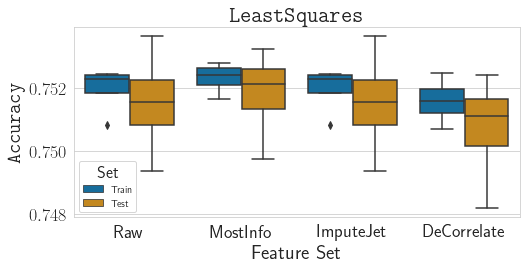

In [56]:
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(feature_masks)+2, k_fold), float)
acc_test = np.empty((len(feature_masks)+2, k_fold), float)
    
for i, features in enumerate(feature_masks):
    print('Feature Set: ', labels[i])
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Run evaluation
            w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                        test_split[1], test_split[0], features)
            acc_train[i, k] = acc_tr
            acc_test[i, k] = acc_te
            
            k+=1
            
print('Feature Set: Impute')
col_index = [FEATURE_NAMES.index(i) for i in JET_NOT_DEFINED]
x_train_imp = x_train.copy()
x_train_imp[x_train_imp == -999] = -100

x_eval_imp = x_eval.copy()
x_eval_imp[x_eval_imp == -999] = -100

features = generate_mask([])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-2, k] = acc_tr
        acc_test[-2, k] = acc_te

        k+=1
        
print('Feature Set: Indicator')
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

x_ind = (x_train[:, JET_NUM_IDX] > 1).astype(int)
# x_train_imp = np.delete(x_train, JET_NUM_IDX, axis=1)
x_train_imp = np.concatenate([x_train, np.expand_dims(x_ind, axis=1)], axis=1)

features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
features = np.concatenate([features, [True]])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_least_squares(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-1, k] = acc_tr
        acc_test[-1, k] = acc_te

        k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{LeastSquares}$')
fig.savefig('../report/compare_features_ls.pdf', bbox_inches='tight')

# 2 Ridge Regresion

In [57]:
def run_ridge(y_train, x_train, y_eval, x_eval, feature_mask):
    # Remove unwanted features
    x_train = x_train[:, feature_mask]
    x_eval = x_eval[:, feature_mask]
    
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)
    
    lambdas = np.logspace(-8, -1, 10)
    k_fold = 4

    # Hyperparameter optimisation
    acc_train = np.empty((len(lambdas), k_fold), float)
    acc_test = np.empty((len(lambdas), k_fold), float)

    for l, lambda_ in enumerate(lambdas):
        k = 0
        for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Train
            w, loss = ridge_regression(train_split[1], train_split[0], lambda_)
            acc_tr = eval_model(train_split[1], train_split[0], w)
            acc_train[l, k] = acc_tr

            # Test
            acc_te = eval_model(test_split[1], test_split[0], w)
            acc_test[l, k] = acc_te

            k += 1
#     fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

    avg_acc_test = np.mean(acc_test, axis=1)
    lambda_opt_ridge = lambdas[np.argmax(avg_acc_test)]

    print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt_ridge))
    
    # Run training
    w, loss = ridge_regression(y_train, x_train, lambda_opt_ridge)
#     print(f'Training loss: {loss_ridge}')

    acc_tr = eval_model(y_train, x_train, w)
#     print(f'Training accuracy: {acc}')

    acc_te = eval_model(y_eval, x_eval, w)
    print(f'Test accuracy: {acc_te}')
    
    
    return w, loss, acc_tr, acc_te
    


Feature Set Raw
Maximum test accuracy 0.7419617822747775 with lambda 0.0004641588833612782
Test accuracy: 0.74544
Maximum test accuracy 0.7413293916859686 with lambda 0.0027825594022071257
Test accuracy: 0.7404114285714286
Maximum test accuracy 0.7402169937827623 with lambda 0.0027825594022071257
Test accuracy: 0.74208
Maximum test accuracy 0.7470056686578082 with lambda 1.2915496650148827e-05
Test accuracy: 0.7490971428571429

Feature Set MostInfo
Maximum test accuracy 0.742434170425454 with lambda 0.0004641588833612782
Test accuracy: 0.7456
Maximum test accuracy 0.7418703523101304 with lambda 0.0004641588833612782
Test accuracy: 0.7434514285714285
Maximum test accuracy 0.7399731805437034 with lambda 0.0027825594022071257
Test accuracy: 0.7425371428571429
Maximum test accuracy 0.7477447275387052 with lambda 1.2915496650148827e-05
Test accuracy: 0.7499428571428571

Feature Set: ImputeJet
Maximum test accuracy 0.7419617822747775 with lambda 0.0004641588833612782
Test accuracy: 0.74544


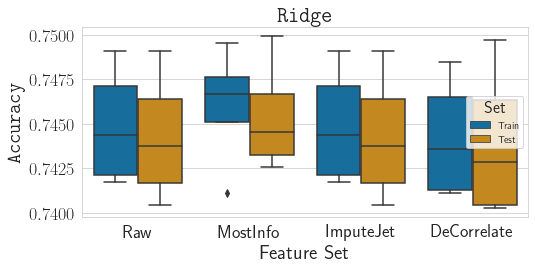

In [58]:
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(labels), k_fold), float)
acc_test = np.empty((len(labels), k_fold), float)
    
for i, features in enumerate(feature_masks):
    print('\nFeature Set', labels[i])
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Run evaluation
            w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                        test_split[1], test_split[0], features)
            acc_train[i, k] = acc_tr
            acc_test[i, k] = acc_te
            
            k+=1
            
print('\nFeature Set: ImputeJet')
col_index = [FEATURE_NAMES.index(i) for i in JET_NOT_DEFINED]
x_train_imp = x_train.copy()
x_train_imp[x_train_imp == -999] = -100

x_eval_imp = x_eval.copy()
x_eval_imp[x_eval_imp == -999] = -100

features = generate_mask([])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-2, k] = acc_tr
        acc_test[-2, k] = acc_te

        k+=1
        
print('\nFeature Set: DeCorrelate')
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

x_ind = (x_train[:, JET_NUM_IDX] > 1).astype(int)
# x_train_imp = np.delete(x_train, JET_NUM_IDX, axis=1)
x_train_imp = np.concatenate([x_train, np.expand_dims(x_ind, axis=1)], axis=1)

features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
features = np.concatenate([features, [True]])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_ridge(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-1, k] = acc_tr
        acc_test[-1, k] = acc_te

        k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{Ridge}$')
fig.savefig('../report/compare_features_ridge.pdf', bbox_inches='tight')

# 3 Logistic Regression

In [59]:
def run_logistic(y_train, x_train, y_eval, x_eval, feature_mask):
    # Remove unwanted features
    x_train = x_train[:, feature_mask]
    x_eval = x_eval[:, feature_mask]
    
    # Standardise to training mean and s.d.
    x_train, mean_x, std_x = standardise(x_train)
    x_eval = standardise_to_fixed(x_eval, mean_x, std_x)

    tx_train = np.c_[np.ones(x_train.shape[0]), x_train]
    tx_eval = np.c_[np.ones(x_eval.shape[0]), x_eval]
    
    gamma = 0.01
    max_iters = 10000
    w_initial = np.ones(tx_train.shape[1])

    # Run gradient descent 
    w, loss = logistic_regression_mean(y_train, tx_train, w_initial, max_iters, gamma, threshold=1e-6)
#     print(f'Training loss: {loss_lr}')

    acc_tr = eval_model(y_train, tx_train, w, thresh=0.5)
#     print(f'Training accuracy: {acc}')

    acc_te = eval_model(y_eval, tx_eval, w, thresh=0.5)
    print(f'Testing accuracy: {acc_te}')
    
    return w, loss, acc_tr, acc_te

In [60]:
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(feature_masks)+2, k_fold), float)
acc_test = np.empty((len(feature_masks)+2, k_fold), float)
    
for i, features in enumerate(feature_masks):
    print('\nFeature Set: ', labels[i])
    k = 0
    for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Run evaluation
            w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                        test_split[1], test_split[0], features)
            acc_train[i, k] = acc_tr
            acc_test[i, k] = acc_te
            
            k+=1
            
print('\nFeature Set: Impute')
col_index = [FEATURE_NAMES.index(i) for i in JET_NOT_DEFINED]
x_train_imp = x_train.copy()
x_train_imp[x_train_imp == -999] = -100

x_eval_imp = x_eval.copy()
x_eval_imp[x_eval_imp == -999] = -100

features = generate_mask([])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-2, k] = acc_tr
        acc_test[-2, k] = acc_te

        k+=1
        
print('\nFeature Set: Indicator')
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

x_ind = (x_train[:, JET_NUM_IDX] > 1).astype(int)
# x_train_imp = np.delete(x_train, JET_NUM_IDX, axis=1)
x_train_imp = np.concatenate([x_train, np.expand_dims(x_ind, axis=1)], axis=1)

features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
features = np.concatenate([features, [True]])

k = 0
for train_split, test_split in k_fold_iter(y_train, x_train_imp, k_fold):
        # Run evaluation
        w, loss, acc_tr, acc_te = run_logistic(train_split[1], train_split[0], 
                                                    test_split[1], test_split[0], features)
        acc_train[-1, k] = acc_tr
        acc_test[-1, k] = acc_te

        k+=1
            
fig = compare_features_visualisation(acc_train, acc_test, labels, '$\mathtt{LogReg}$')
fig.savefig('../report/compare_features_logreg.pdf', bbox_inches='tight')


Feature Set:  Raw


KeyboardInterrupt: 

# -------------

# Compare model performance on best performing feature set 

##### Data Processing

In [62]:
JET_NUM_IDX = FEATURE_NAMES.index('PRI_jet_num')

def feature_transform(x):
    x_ind = (x[:, JET_NUM_IDX] > 1).astype(int)
    x = np.concatenate([x, np.expand_dims(x_ind, axis=1)], axis=1)

    features = generate_mask(['DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet'])
    features = np.concatenate([features, [True]])

    x = x[:, features]
    
    return x

fx_train = feature_transform(x_train)
fx_eval = feature_transform(x_eval)

fx_train, mu_x, sigma_x = standardise(fx_train)
fx_eval = standardise_to_fixed(fx_eval, mu_x, sigma_x)

tx_train = np.c_[np.ones(fx_train.shape[0]), fx_train]
tx_eval = np.c_[np.ones(fx_eval.shape[0]), fx_eval]

fx_train.shape

(175000, 179)

##### Baseline

In [98]:
# Get baseline frequency of the two classes in training data
prior_probs = [sum(y_train == 1)/len(y_train), sum(y_train == 0)/len(y_train)]

# Test error on evaluation set
y_eval_pred = np.random.choice([1., 0], size=len(y_eval), p=prior_probs)

acc_baseline = get_accuracy(y_eval_pred, y_eval)

print(f'Testing Accuracy: {acc_baseline}')

Testing Accuracy: 0.5495733333333334


##### Train LeastSquares

In [99]:
# Get linear least-squares model
w_ls, loss_ls = least_squares(y_train, fx_train)
print(f'Training loss: {loss_ls}')

# Get training accuracy
acc_tr  = eval_model(y_train, fx_train, w_ls, thresh=0)
print(f'Training accuracy: {acc_tr}')

# Get accuracy on evaluation set
acc_ls = eval_model(y_eval, fx_eval, w_ls, thresh=0)
print(f'Test Accuracy: {acc_ls}')

Training loss: 0.13826596181052767
Training accuracy: 0.7304742857142857
Test Accuracy: 0.7284


##### Train Ridge

In [100]:
# Run cross val
lambdas = np.logspace(-9, 0, 20)
k_fold = 4

# Hyperparameter optimisation
acc_train = np.empty((len(lambdas), k_fold), float)
acc_test = np.empty((len(lambdas), k_fold), float)

for l, lambda_ in enumerate(lambdas):
    print(f'lambda: {lambda_}')
    k = 0
    for train_split, test_split in k_fold_iter(y_train, fx_train, k_fold):
        # Train
        w, loss = ridge_regression(train_split[1], train_split[0], lambda_)
        acc_tr = eval_model(train_split[1], train_split[0], w)
        acc_train[l, k] = acc_tr

        # Test
        acc_te = eval_model(test_split[1], test_split[0], w)
        acc_test[l, k] = acc_te

        k += 1

lambda: 1e-09
lambda: 2.9763514416313133e-09
lambda: 8.858667904100832e-09
lambda: 2.6366508987303555e-08
lambda: 7.847599703514607e-08
lambda: 2.3357214690901212e-07
lambda: 6.951927961775605e-07
lambda: 2.06913808111479e-06
lambda: 6.158482110660255e-06
lambda: 1.8329807108324338e-05
lambda: 5.4555947811685143e-05
lambda: 0.0001623776739188721
lambda: 0.0004832930238571752
lambda: 0.0014384498882876629
lambda: 0.004281332398719387
lambda: 0.012742749857031322
lambda: 0.03792690190732246
lambda: 0.11288378916846883
lambda: 0.33598182862837744
lambda: 1.0


Maximum test accuracy 0.72644 with lambda 1e-09


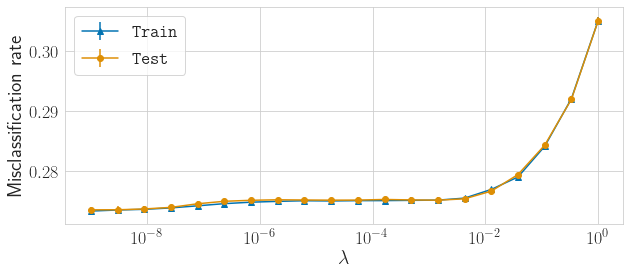

In [101]:
fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

avg_acc_test = np.mean(acc_test, axis=1)
lambda_opt_ridge = lambdas[np.argmax(avg_acc_test)]

print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt_ridge))

fig.savefig('../report/ridge_crossval.pdf', bbox_inches='tight')

In [102]:
# Run training
w_ridge, loss_ridge = ridge_regression(y_train, fx_train, lambda_opt_ridge)
print(f'Training loss: {loss_ridge}')

acc = eval_model(y_train, fx_train, w_ridge)
print(f'Training accuracy: {acc}')

acc_ridge = eval_model(y_eval, fx_eval, w_ridge)
print(f'Test accuracy: {acc_ridge}')

Training loss: 0.13933829612385162
Training accuracy: 0.7264914285714286
Test accuracy: 0.7260133333333333


##### Train LogReg

In [63]:
# Run cross-validation to find optimal step-size
gammas = np.logspace(-7, -2, 5)
k_fold = 4

max_iters = 5000
w_initial = np.ones(tx_train.shape[1])

# Hyperparameter optimisation
acc_train = np.empty((len(gammas), k_fold), float)
acc_test = np.empty((len(gammas), k_fold), float)

for g, gamma in enumerate(gammas):
    k = 0
    for train_split, test_split in k_fold_iter(y_train, tx_train, k_fold):
        # Train
        w, loss = logistic_regression_mean(train_split[1], train_split[0], w_initial, 
                                           max_iters, gamma, threshold=1e-6, verbose=False)
        
        acc_tr = eval_model(train_split[1], train_split[0], w, thresh=0.5)
        acc_train[g, k] = acc_tr

        # Test
        acc_te = eval_model(test_split[1], test_split[0], w, thresh=0.5)
        acc_test[g, k] = acc_te

        k += 1

Loss convergence:Terminate because loss did not change by more than threshold.
Loss convergence:Terminate because loss did not change by more than threshold.
Loss convergence:Terminate because loss did not change by more than threshold.
Loss convergence:Terminate because loss did not change by more than threshold.


KeyboardInterrupt: 

Maximum test accuracy 0.7230571428571428 with gamma 0.01


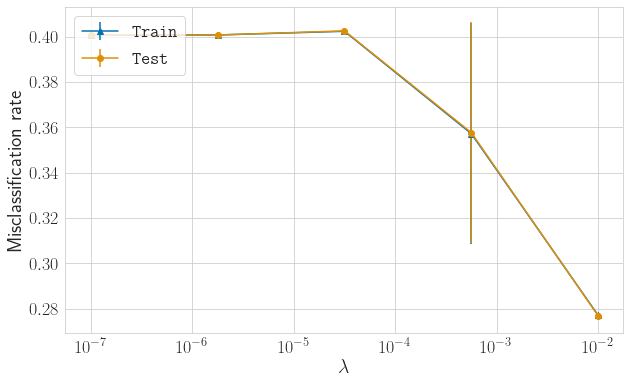

In [181]:
fig = cross_validation_visualization(gammas, 1-acc_train, 1-acc_test)
fig.savefig('../report/crossval_lr.pdf', bbox_inches='tight')
avg_acc_test = np.mean(acc_test, axis=1)
gamma_opt_lr = gammas[np.argmax(avg_acc_test)]

print('Maximum test accuracy {} with gamma {}'.format(np.max(avg_acc_test), gamma_opt_lr))

In [182]:
max_iters = 15000
w_initial = np.ones(tx_train.shape[1])

# Run gradient descent 
w_lr, loss_lr = logistic_regression_mean(y_train, tx_train, w_initial, max_iters, gamma_opt_lr, 
                                    threshold=1e-7, verbose=True)
print(f'Training loss: {loss_lr}')

acc = eval_model(y_train, tx_train, w_lr, thresh=0.5)
print(f'Training accuracy: {acc}')

acc_lr = eval_model(y_eval, tx_eval, w_lr, thresh=0.5)
print(f'Testing accuracy: {acc_lr}')

Gradient Descent (0/14999): loss=4.9399464656485925, gradient=1.1070150667360843
Gradient Descent (100/14999): loss=3.744638955603192, gradient=1.0757625234785748
Gradient Descent (200/14999): loss=2.660183871882455, gradient=0.9939685748542625
Gradient Descent (300/14999): loss=1.8358315281073783, gradient=0.8008442314450439
Gradient Descent (400/14999): loss=1.373341534216789, gradient=0.5664264578414981
Gradient Descent (500/14999): loss=1.1283284058888108, gradient=0.4414843709133819
Gradient Descent (600/14999): loss=0.9608052299096556, gradient=0.3813570647365515
Gradient Descent (700/14999): loss=0.834100959239845, gradient=0.33095041231472316
Gradient Descent (800/14999): loss=0.7403573840109454, gradient=0.2818153614972203
Gradient Descent (900/14999): loss=0.6735010928901823, gradient=0.23613902384085597
Gradient Descent (1000/14999): loss=0.6270053126903851, gradient=0.19614762202692698
Gradient Descent (1100/14999): loss=0.5950191683662266, gradient=0.16260812861450613
Grad

Gradient Descent (9700/14999): loss=0.5007412268347543, gradient=0.008094871688005649
Gradient Descent (9800/14999): loss=0.5006763996631624, gradient=0.008009585446565057
Gradient Descent (9900/14999): loss=0.5006129295013376, gradient=0.007925420622961078
Gradient Descent (10000/14999): loss=0.5005507844828353, gradient=0.007842356468902077
Gradient Descent (10100/14999): loss=0.5004899336170957, gradient=0.007760372869899766
Gradient Descent (10200/14999): loss=0.500430346759205, gradient=0.007679450313249064
Gradient Descent (10300/14999): loss=0.500371994581067, gradient=0.00759956985823273
Gradient Descent (10400/14999): loss=0.5003148485438939, gradient=0.007520713108367252
Gradient Descent (10500/14999): loss=0.5002588808719375, gradient=0.007442862185523497
Gradient Descent (10600/14999): loss=0.5002040645273809, gradient=0.007365999705770883
Gradient Descent (10700/14999): loss=0.5001503731863235, gradient=0.007290108756807825
Gradient Descent (10800/14999): loss=0.5000977812

# Compare model performance 

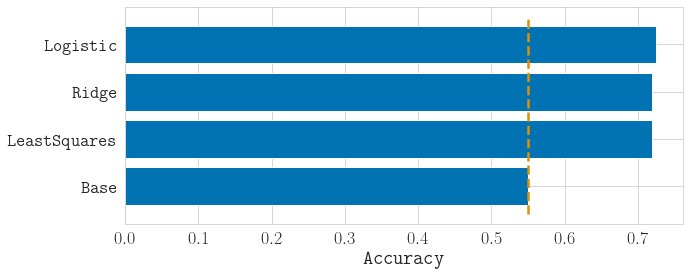

In [204]:
accuracy = [acc_baseline, acc_ls, acc_ridge, acc_lr]
labels = ['$\mathtt{Base}$', '$\mathtt{LeastSquares}$', '$\mathtt{Ridge}$',  
          '$\mathtt{Logistic}$']

fig = model_comparison_visualization(accuracy, labels, acc_baseline)
fig.savefig('../report/model_comparison_basic.pdf', bbox_inches='tight')

# Final training and test set prediction 

In [64]:
# Get all labelled records
y, x, ids = load_csv_data(path.join(DATA_PATH, 'train.csv'))

for i in range(30):
    meani=x[:,i][x[:,i] != -999.0].mean()
    x[:,i][x[:,i] == -999.0]=meani

In [68]:
FEATURE_NAMES = list(df_train_x)
FEATURE_NAMES=FEATURE_NAMES+[str(i) for i in range(30-len(FEATURE_NAMES))]

# Apply feature transform
fx = feature_transform(x)

fx=np.hstack((fx,fx**2,fx**3,fx**4,fx**5,fx**6))

In [69]:
# Standardise to mean and s.d.
fx, mu_x, sigma_x = standardise(fx)

# Add offset term
tx = np.c_[np.ones(len(y)), fx]

In [76]:
max_iters = 10000
w_initial = np.ones(tx.shape[1])

# Run gradient descent 
w, loss = logistic_regression_mean(y, tx, BEST, max_iters, 0.01, 
                                    threshold=1e-7, verbose=True)
# w, loss = logistic_regression_mean(y, tx, BEST3, max_iters, 0.01, 
#                                      threshold=1e-7, verbose=True)
print(f'Training loss: {loss}')

acc = eval_model(y, tx, w, thresh=0.5)
print(f'Training accuracy: {acc}')

Gradient Descent (0/9999): loss=0.45560576772123523, gradient=0.010194141353334176
Gradient Descent (0/9999): loss=0.45560576772123523, gradient=0.010194141353334176, w=[-1.06144914e+00  8.96702524e-01 -7.21073060e-01 -1.69983165e-01
  4.21566509e-01 -1.07124563e-01  1.32660199e+00 -1.31423324e-01
  8.72208535e-02 -3.82024356e-01  2.06149537e-01  1.02022626e-01
  1.06304907e+00 -3.50993321e-04  6.38027246e-02  5.77119579e-01
  1.33144657e-02  9.01194817e-02 -1.46251427e-01  4.17595058e-02
  8.78517392e-02 -1.02154916e-01  4.87152088e-01  8.48690265e-03
  6.08681268e-02  2.52683595e-01  2.38780653e-02  2.66522078e-02
  3.25799529e-03  2.66214724e-02 -8.45789581e-01  5.09364830e-02
 -1.33494518e+00  9.36600544e-02  4.56634120e-02  4.25057211e-01
  9.45714072e-01 -2.41559297e-01  2.20188025e-02  1.44732026e-01
  5.24698352e-02 -4.92715602e-01 -7.67560464e-02  5.08570817e-02
  1.20536079e-01 -1.64348544e-01  7.02292582e-02  3.72556012e-01
  5.30927298e-02 -1.98255915e-01 -1.22065909e-01 -2

Gradient Descent (315/9999): loss=0.4553510257438113, gradient=0.009763850926220749
Gradient Descent (320/9999): loss=0.45534720304874166, gradient=0.009755105719386653
Gradient Descent (325/9999): loss=0.4553433878303967, gradient=0.009746419098766964
Gradient Descent (330/9999): loss=0.45533958002785585, gradient=0.009737796458773866
Gradient Descent (335/9999): loss=0.4553357795765712, gradient=0.009729242618887189
Gradient Descent (340/9999): loss=0.4553319864088586, gradient=0.009720761829288764
Gradient Descent (345/9999): loss=0.45532820045437283, gradient=0.009712357783239579
Gradient Descent (350/9999): loss=0.45532442164056725, gradient=0.009704033635257769
Gradient Descent (355/9999): loss=0.45532064989312565, gradient=0.009695792024130992
Gradient Descent (360/9999): loss=0.4553168851363703, gradient=0.009687635099804224
Gradient Descent (365/9999): loss=0.4553131272936425, gradient=0.009679564553219347
Gradient Descent (370/9999): loss=0.45530937628765045, gradient=0.00967

Gradient Descent (805/9999): loss=0.45500286513313826, gradient=0.009202951071491047
Gradient Descent (810/9999): loss=0.4549995229538958, gradient=0.00919902044881627
Gradient Descent (815/9999): loss=0.45499618418157295, gradient=0.009195108795845076
Gradient Descent (820/9999): loss=0.45499284879904117, gradient=0.009191215892078107
Gradient Descent (825/9999): loss=0.45498951678933747, gradient=0.009187341522219897
Gradient Descent (830/9999): loss=0.4549861881356615, gradient=0.009183485475989298
Gradient Descent (835/9999): loss=0.4549828628213714, gradient=0.009179647547936928
Gradient Descent (840/9999): loss=0.4549795408299821, gradient=0.009175827537269058
Gradient Descent (845/9999): loss=0.4549762221451611, gradient=0.009172025247678019
Gradient Descent (850/9999): loss=0.45497290675072694, gradient=0.009168240487178722
Gradient Descent (855/9999): loss=0.45496959463064585, gradient=0.009164473067951177
Gradient Descent (860/9999): loss=0.4549662857690293, gradient=0.009160

Gradient Descent (1120/9999): loss=0.4547983633816391, gradient=0.008985746859540875
Gradient Descent (1125/9999): loss=0.45479520763600406, gradient=0.008982710721479699
Gradient Descent (1130/9999): loss=0.45479205446046933, gradient=0.00897968519674098
Gradient Descent (1135/9999): loss=0.4547889038448546, gradient=0.008976670199513932
Gradient Descent (1140/9999): loss=0.4547857557790554, gradient=0.008973665644767512
Gradient Descent (1145/9999): loss=0.45478261025304695, gradient=0.008970671448238913
Gradient Descent (1150/9999): loss=0.4547794672568808, gradient=0.008967687526422664
Gradient Descent (1155/9999): loss=0.454776326780685, gradient=0.008964713796560147
Gradient Descent (1160/9999): loss=0.4547731888146637, gradient=0.008961750176629773
Gradient Descent (1165/9999): loss=0.4547700533490961, gradient=0.0089587965853375
Gradient Descent (1170/9999): loss=0.45476692037433575, gradient=0.008955852942107984
Gradient Descent (1175/9999): loss=0.4547637898808111, gradient=0

Gradient Descent (1605/9999): loss=0.45450295617298503, gradient=0.008730269523527954
Gradient Descent (1610/9999): loss=0.45450001194229395, gradient=0.008727956359233261
Gradient Descent (1615/9999): loss=0.454497069578879, gradient=0.008725648256706828
Gradient Descent (1620/9999): loss=0.45449412907774583, gradient=0.00872334518131636
Gradient Descent (1625/9999): loss=0.45449119043393316, gradient=0.008721047098757364
Gradient Descent (1630/9999): loss=0.45448825364251266, gradient=0.008718753975048968
Gradient Descent (1635/9999): loss=0.45448531869858816, gradient=0.008716465776530066
Gradient Descent (1640/9999): loss=0.4544823855972953, gradient=0.008714182469855131
Gradient Descent (1645/9999): loss=0.4544794543338021, gradient=0.008711904021990449
Gradient Descent (1650/9999): loss=0.4544765249033072, gradient=0.008709630400209962
Gradient Descent (1655/9999): loss=0.45447359730104103, gradient=0.00870736157209148
Gradient Descent (1660/9999): loss=0.45447067152226506, gradi

Gradient Descent (2005/9999): loss=0.4542729537469027, gradient=0.008558796077915628
Gradient Descent (2010/9999): loss=0.454270145418264, gradient=0.008556799669984658
Gradient Descent (2015/9999): loss=0.45426733864136215, gradient=0.00855480630567531
Gradient Descent (2020/9999): loss=0.4542645334131217, gradient=0.008552815966433909
Gradient Descent (2025/9999): loss=0.4542617297304859, gradient=0.008550828633815944
Gradient Descent (2030/9999): loss=0.45425892759041425, gradient=0.008548844289484762
Gradient Descent (2035/9999): loss=0.4542561269898843, gradient=0.008546862915210144
Gradient Descent (2040/9999): loss=0.4542533279258905, gradient=0.008544884492867087
Gradient Descent (2045/9999): loss=0.45425053039544394, gradient=0.008542909004434511
Gradient Descent (2050/9999): loss=0.45424773439557325, gradient=0.008540936431993917
Gradient Descent (2055/9999): loss=0.45424493992332343, gradient=0.008538966757728323
Gradient Descent (2060/9999): loss=0.4542421469757563, gradien

Gradient Descent (2490/9999): loss=0.45400737185976997, gradient=0.008376894695029323
Gradient Descent (2495/9999): loss=0.454004701991517, gradient=0.008375120045441244
Gradient Descent (2500/9999): loss=0.4540020334450953, gradient=0.008373347027011774
Gradient Descent (2505/9999): loss=0.45399936621873815, gradient=0.008371575628658427
Gradient Descent (2510/9999): loss=0.45399670031068884, gradient=0.008369805839369044
Gradient Descent (2515/9999): loss=0.45399403571920083, gradient=0.008368037648202058
Gradient Descent (2520/9999): loss=0.45399137244253773, gradient=0.00836627104428671
Gradient Descent (2525/9999): loss=0.45398871047897327, gradient=0.00836450601682327
Gradient Descent (2530/9999): loss=0.45398604982679086, gradient=0.008362742555083425
Gradient Descent (2535/9999): loss=0.4539833904842838, gradient=0.00836098064841042
Gradient Descent (2540/9999): loss=0.4539807324497556, gradient=0.0083592202862194
Gradient Descent (2545/9999): loss=0.45397807572151877, gradient

Gradient Descent (2975/9999): loss=0.45375431989989673, gradient=0.008210976570493564
Gradient Descent (2980/9999): loss=0.4537517713100903, gradient=0.008209319899276682
Gradient Descent (2985/9999): loss=0.45374922390897837, gradient=0.008207664152079084
Gradient Descent (2990/9999): loss=0.453746677695491, gradient=0.008206009325764568
Gradient Descent (2995/9999): loss=0.4537441326685612, gradient=0.008204355417280346
Gradient Descent (3000/9999): loss=0.4537415888271266, gradient=0.008202702423656639
Gradient Descent (3000/9999): loss=0.4537415888271266, gradient=0.008202702423656639, w=[-1.07933816e+00  9.61808959e-01 -7.63174627e-01 -1.60561644e-01
  4.60546579e-01 -8.09501313e-02  1.37198927e+00 -1.38396765e-01
  8.34313642e-02 -4.19723756e-01  1.99596029e-01  9.29595746e-02
  1.07253757e+00 -2.85008204e-04  5.47878164e-02  5.64197491e-01
  1.30584468e-02  7.91273736e-02 -1.40054918e-01  3.66313758e-02
  8.37537694e-02 -1.05753461e-01  4.92890242e-01  7.24901187e-03
  5.0369979

Gradient Descent (3285/9999): loss=0.4535985165765671, gradient=0.008109934947854048
Gradient Descent (3290/9999): loss=0.4535960397846834, gradient=0.008108332494655946
Gradient Descent (3295/9999): loss=0.45359356412077734, gradient=0.008106730907258528
Gradient Descent (3300/9999): loss=0.4535910895839329, gradient=0.008105130186506854
Gradient Descent (3305/9999): loss=0.4535886161732348, gradient=0.00810353033328384
Gradient Descent (3310/9999): loss=0.4535861438877693, gradient=0.008101931348509325
Gradient Descent (3315/9999): loss=0.4535836727266234, gradient=0.00810033323313906
Gradient Descent (3320/9999): loss=0.4535812026888854, gradient=0.008098735988163795
Gradient Descent (3325/9999): loss=0.45357873377364444, gradient=0.008097139614608301
Gradient Descent (3330/9999): loss=0.45357626597999096, gradient=0.008095544113530436
Gradient Descent (3335/9999): loss=0.45357379930701636, gradient=0.00809394948602013
Gradient Descent (3340/9999): loss=0.45357133375381237, gradient

Gradient Descent (3770/9999): loss=0.45336338713720437, gradient=0.007958725361567878
Gradient Descent (3775/9999): loss=0.4533610155938403, gradient=0.007957213330616893
Gradient Descent (3780/9999): loss=0.4533586450923523, gradient=0.007955702297931676
Gradient Descent (3785/9999): loss=0.4533562756318714, gradient=0.007954192264364083
Gradient Descent (3790/9999): loss=0.4533539072115295, gradient=0.00795268323074184
Gradient Descent (3795/9999): loss=0.45335153983045884, gradient=0.007951175197868338
Gradient Descent (3800/9999): loss=0.45334917348779147, gradient=0.00794966816652245
Gradient Descent (3805/9999): loss=0.4533468081826611, gradient=0.007948162137458466
Gradient Descent (3810/9999): loss=0.45334444391420103, gradient=0.007946657111405884
Gradient Descent (3815/9999): loss=0.4533420806815458, gradient=0.007945153089069361
Gradient Descent (3820/9999): loss=0.45333971848382953, gradient=0.007943650071128574
Gradient Descent (3825/9999): loss=0.45333735732018776, gradie

Gradient Descent (4080/9999): loss=0.45321828909758965, gradient=0.007866885378210358
Gradient Descent (4085/9999): loss=0.45321598053044576, gradient=0.007865435900267842
Gradient Descent (4090/9999): loss=0.45321367295254994, gradient=0.007863987426070836
Gradient Descent (4095/9999): loss=0.45321136636308007, gradient=0.007862539954955124
Gradient Descent (4100/9999): loss=0.45320906076121537, gradient=0.007861093486235543
Gradient Descent (4105/9999): loss=0.45320675614613615, gradient=0.007859648019206099
Gradient Descent (4110/9999): loss=0.45320445251702396, gradient=0.007858203553140167
Gradient Descent (4115/9999): loss=0.453202149873061, gradient=0.007856760087290728
Gradient Descent (4120/9999): loss=0.45319984821343084, gradient=0.007855317620890536
Gradient Descent (4125/9999): loss=0.4531975475373181, gradient=0.007853876153152363
Gradient Descent (4130/9999): loss=0.4531952478439087, gradient=0.00785243568326918
Gradient Descent (4135/9999): loss=0.45319294913238933, gra

Gradient Descent (4565/9999): loss=0.45299884696066456, gradient=0.007730803050629721
Gradient Descent (4570/9999): loss=0.45299663070257445, gradient=0.007729445526364435
Gradient Descent (4575/9999): loss=0.45299441535980783, gradient=0.007728088877342158
Gradient Descent (4580/9999): loss=0.4529922009316678, gradient=0.007726733101943737
Gradient Descent (4585/9999): loss=0.45298998741745916, gradient=0.007725378198551744
Gradient Descent (4590/9999): loss=0.45298777481648783, gradient=0.007724024165550599
Gradient Descent (4595/9999): loss=0.45298556312806126, gradient=0.007722671001326766
Gradient Descent (4600/9999): loss=0.45298335235148773, gradient=0.0077213187042690975
Gradient Descent (4605/9999): loss=0.45298114248607757, gradient=0.007719967272768874
Gradient Descent (4610/9999): loss=0.4529789335311419, gradient=0.007718616705220079
Gradient Descent (4615/9999): loss=0.45297672548599344, gradient=0.007717267000019641
Gradient Descent (4620/9999): loss=0.45297451834994557,

Gradient Descent (5005/9999): loss=0.45280724654666415, gradient=0.007614524824757153
Gradient Descent (5010/9999): loss=0.4528051083029994, gradient=0.007613238725609973
Gradient Descent (5015/9999): loss=0.4528029709177873, gradient=0.007611953384300624
Gradient Descent (5020/9999): loss=0.45280083439042373, gradient=0.007610668799947289
Gradient Descent (5025/9999): loss=0.4527986987203048, gradient=0.007609384971680395
Gradient Descent (5030/9999): loss=0.45279656390682704, gradient=0.007608101898642618
Gradient Descent (5035/9999): loss=0.4527944299493887, gradient=0.007606819579988887
Gradient Descent (5040/9999): loss=0.4527922968473868, gradient=0.007605538014886453
Gradient Descent (5045/9999): loss=0.45279016460022103, gradient=0.007604257202514794
Gradient Descent (5050/9999): loss=0.45278803320729055, gradient=0.007602977142065709
Gradient Descent (5055/9999): loss=0.4527859026679954, gradient=0.007601697832743261
Gradient Descent (5060/9999): loss=0.45278377298173617, grad

Gradient Descent (5485/9999): loss=0.4526058050328477, gradient=0.0074944282465115985
Gradient Descent (5490/9999): loss=0.45260374651171587, gradient=0.007493212525171203
Gradient Descent (5495/9999): loss=0.4526016887928724, gradient=0.007491997527055304
Gradient Descent (5500/9999): loss=0.4525996318757408, gradient=0.007490783252207128
Gradient Descent (5505/9999): loss=0.452597575759745, gradient=0.007489569700674484
Gradient Descent (5510/9999): loss=0.45259552044430856, gradient=0.007488356872509756
Gradient Descent (5515/9999): loss=0.4525934659288553, gradient=0.007487144767769764
Gradient Descent (5520/9999): loss=0.4525914122128086, gradient=0.0074859333865155975
Gradient Descent (5525/9999): loss=0.4525893592955921, gradient=0.0074847227288125494
Gradient Descent (5530/9999): loss=0.4525873071766296, gradient=0.007483512794729921
Gradient Descent (5535/9999): loss=0.4525852558553445, gradient=0.007482303584340958
Gradient Descent (5540/9999): loss=0.45258320533116064, gradi

Gradient Descent (5965/9999): loss=0.4524117629886705, gradient=0.007381031344442694
Gradient Descent (5970/9999): loss=0.4524097788542624, gradient=0.0073798855312072476
Gradient Descent (5975/9999): loss=0.4524077954666542, gradient=0.007378740450612902
Gradient Descent (5980/9999): loss=0.45240581282526715, gradient=0.007377596102672855
Gradient Descent (5985/9999): loss=0.4524038309295225, gradient=0.007376452487396494
Gradient Descent (5990/9999): loss=0.45240184977884135, gradient=0.007375309604789276
Gradient Descent (5995/9999): loss=0.4523998693726449, gradient=0.007374167454852794
Gradient Descent (6000/9999): loss=0.4523978897103545, gradient=0.007373026037584635
Gradient Descent (6000/9999): loss=0.4523978897103545, gradient=0.007373026037584635, w=[-1.09575648e+00  1.02110655e+00 -7.92463088e-01 -1.48318048e-01
  5.01599234e-01 -5.48722336e-02  1.41232817e+00 -1.41995018e-01
  8.02553738e-02 -4.48333268e-01  1.90976175e-01  8.26265047e-02
  1.07349880e+00 -4.48044082e-04  

Gradient Descent (6275/9999): loss=0.4522901370070023, gradient=0.007311374537184187
Gradient Descent (6280/9999): loss=0.4522881980830633, gradient=0.007310274014117276
Gradient Descent (6285/9999): loss=0.4522862598702443, gradient=0.0073091742164600685
Gradient Descent (6290/9999): loss=0.45228432236797556, gradient=0.007308075143957209
Gradient Descent (6295/9999): loss=0.4522823855756879, gradient=0.007306976796349002
Gradient Descent (6300/9999): loss=0.452280449492812, gradient=0.007305879173371502
Gradient Descent (6305/9999): loss=0.4522785141187788, gradient=0.007304782274756482
Gradient Descent (6310/9999): loss=0.4522765794530197, gradient=0.007303686100231424
Gradient Descent (6315/9999): loss=0.4522746454949665, gradient=0.007302590649519576
Gradient Descent (6320/9999): loss=0.4522727122440508, gradient=0.007301495922339983
Gradient Descent (6325/9999): loss=0.45227077969970486, gradient=0.0073004019184074575
Gradient Descent (6330/9999): loss=0.4522688478613611, gradien

Gradient Descent (6760/9999): loss=0.45210528945667633, gradient=0.007207949994693721
Gradient Descent (6765/9999): loss=0.4521034169075218, gradient=0.0072069180826832184
Gradient Descent (6770/9999): loss=0.4521015450158701, gradient=0.007205886854387314
Gradient Descent (6775/9999): loss=0.4520996737811903, gradient=0.007204856309237278
Gradient Descent (6780/9999): loss=0.4520978032029514, gradient=0.0072038264466623425
Gradient Descent (6785/9999): loss=0.45209593328062325, gradient=0.007202797266089835
Gradient Descent (6790/9999): loss=0.4520940640136761, gradient=0.007201768766945083
Gradient Descent (6795/9999): loss=0.4520921954015805, gradient=0.007200740948651589
Gradient Descent (6800/9999): loss=0.45209032744380795, gradient=0.007199713810630829
Gradient Descent (6805/9999): loss=0.45208846013983006, gradient=0.007198687352302525
Gradient Descent (6810/9999): loss=0.452086593489119, gradient=0.0071976615730845045
Gradient Descent (6815/9999): loss=0.4520847274911478, grad

Gradient Descent (7070/9999): loss=0.4519904149459532, gradient=0.007145241886045389
Gradient Descent (7075/9999): loss=0.4519885821772692, gradient=0.007144251226511599
Gradient Descent (7080/9999): loss=0.45198675003415756, gradient=0.007143261212528367
Gradient Descent (7085/9999): loss=0.4519849185161211, gradient=0.007142271843445318
Gradient Descent (7090/9999): loss=0.451983087622663, gradient=0.0071412831186114046
Gradient Descent (7095/9999): loss=0.4519812573532865, gradient=0.007140295037374882
Gradient Descent (7100/9999): loss=0.4519794277074963, gradient=0.0071393075990833265
Gradient Descent (7105/9999): loss=0.45197759868479703, gradient=0.007138320803083682
Gradient Descent (7110/9999): loss=0.451975770284694, gradient=0.007137334648722212
Gradient Descent (7115/9999): loss=0.4519739425066932, gradient=0.007136349135344604
Gradient Descent (7120/9999): loss=0.4519721153503013, gradient=0.007135364262295894
Gradient Descent (7125/9999): loss=0.45197028881502527, gradien

Gradient Descent (7555/9999): loss=0.4518154777092422, gradient=0.0070520562136275645
Gradient Descent (7560/9999): loss=0.45181370339041477, gradient=0.007051125090286013
Gradient Descent (7565/9999): loss=0.45181192965161077, gradient=0.007050194548166519
Gradient Descent (7570/9999): loss=0.45181015649238954, gradient=0.007049264586610668
Gradient Descent (7575/9999): loss=0.4518083839123103, gradient=0.0070483352049604065
Gradient Descent (7580/9999): loss=0.451806611910933, gradient=0.007047406402558098
Gradient Descent (7585/9999): loss=0.4518048404878187, gradient=0.007046478178746498
Gradient Descent (7590/9999): loss=0.4518030696425283, gradient=0.0070455505328688006
Gradient Descent (7595/9999): loss=0.4518012993746237, gradient=0.007044623464268591
Gradient Descent (7600/9999): loss=0.45179952968366716, gradient=0.007043696972289906
Gradient Descent (7605/9999): loss=0.4517977605692215, gradient=0.007042771056277179
Gradient Descent (7610/9999): loss=0.45179599203085063, gra

Gradient Descent (8005/9999): loss=0.4516541295344407, gradient=0.00697050681614141
Gradient Descent (8010/9999): loss=0.45165193428953576, gradient=0.006969625426456655
Gradient Descent (8015/9999): loss=0.45164973962382376, gradient=0.006968744560946766
Gradient Descent (8020/9999): loss=0.45164754553689035, gradient=0.006967864219008754
Gradient Descent (8025/9999): loss=0.4516453520283215, gradient=0.0069669844000404095
Gradient Descent (8030/9999): loss=0.4516431590977037, gradient=0.0069661051034402895
Gradient Descent (8035/9999): loss=0.45164096674462445, gradient=0.006965226328607741
Gradient Descent (8040/9999): loss=0.4516387749686709, gradient=0.006964348074942902
Gradient Descent (8045/9999): loss=0.45163658376943167, gradient=0.006963470341846641
Gradient Descent (8050/9999): loss=0.45163439314649556, gradient=0.006962593128720665
Gradient Descent (8055/9999): loss=0.4516322030994515, gradient=0.006961716434967448
Gradient Descent (8060/9999): loss=0.45163001362788946, gr

Gradient Descent (8485/9999): loss=0.451445969657266, gradient=0.006888200152300647
Gradient Descent (8490/9999): loss=0.45144382819883205, gradient=0.006887366449068953
Gradient Descent (8495/9999): loss=0.45144168728212797, gradient=0.006886533215837257
Gradient Descent (8500/9999): loss=0.45143954690678734, gradient=0.006885700452081696
Gradient Descent (8505/9999): loss=0.45143740707244356, gradient=0.006884868157279233
Gradient Descent (8510/9999): loss=0.45143526777873055, gradient=0.0068840363309076455
Gradient Descent (8515/9999): loss=0.451433129025283, gradient=0.0068832049724455785
Gradient Descent (8520/9999): loss=0.4514309908117355, gradient=0.006882374081372497
Gradient Descent (8525/9999): loss=0.4514288531377237, gradient=0.0068815436571687165
Gradient Descent (8530/9999): loss=0.45142671600288325, gradient=0.006880713699315328
Gradient Descent (8535/9999): loss=0.45142457940685055, gradient=0.006879884207294342
Gradient Descent (8540/9999): loss=0.45142244334926224, g

Gradient Descent (8965/9999): loss=0.4512428089648195, gradient=0.00681023572374338
Gradient Descent (8970/9999): loss=0.4512407179011996, gradient=0.006809444868575931
Gradient Descent (8975/9999): loss=0.4512386273460282, gradient=0.0068086544368135115
Gradient Descent (8980/9999): loss=0.45123653729897767, gradient=0.006807864428008464
Gradient Descent (8985/9999): loss=0.4512344477597216, gradient=0.006807074841713884
Gradient Descent (8990/9999): loss=0.4512323587279328, gradient=0.0068062856774835714
Gradient Descent (8995/9999): loss=0.45123027020328554, gradient=0.006805496934872119
Gradient Descent (9000/9999): loss=0.45122818218545385, gradient=0.0068047086134348095
Gradient Descent (9000/9999): loss=0.45122818218545385, gradient=0.0068047086134348095, w=[-1.11043876e+00  1.07585268e+00 -8.14136253e-01 -1.35081005e-01
  5.41731542e-01 -3.04740529e-02  1.44926507e+00 -1.44539749e-01
  7.73357283e-02 -4.71124190e-01  1.81463507e-01  7.16124590e-02
  1.07021855e+00 -7.40559534e-

Gradient Descent (9275/9999): loss=0.45111411232073373, gradient=0.0067619868345713575
Gradient Descent (9280/9999): loss=0.4511120521756775, gradient=0.006761221411126471
Gradient Descent (9285/9999): loss=0.45110999251945527, gradient=0.006760456384674254
Gradient Descent (9290/9999): loss=0.4511079333517613, gradient=0.006759691754810136
Gradient Descent (9295/9999): loss=0.4511058746722908, gradient=0.00675892752113021
Gradient Descent (9300/9999): loss=0.45110381648073866, gradient=0.006758163683231198
Gradient Descent (9305/9999): loss=0.4511017587768006, gradient=0.006757400240710492
Gradient Descent (9310/9999): loss=0.4510997015601722, gradient=0.006756637193166108
Gradient Descent (9315/9999): loss=0.4510976448305499, gradient=0.006755874540196709
Gradient Descent (9320/9999): loss=0.4510955885876298, gradient=0.006755112281401619
Gradient Descent (9325/9999): loss=0.45109353283110926, gradient=0.006754350416380782
Gradient Descent (9330/9999): loss=0.451091477560685, gradien

Gradient Descent (9755/9999): loss=0.4509185248923707, gradient=0.0066902607431869
Gradient Descent (9760/9999): loss=0.4509165103276438, gradient=0.006689531674639422
Gradient Descent (9765/9999): loss=0.4509144962238489, gradient=0.006688802967020121
Gradient Descent (9770/9999): loss=0.45091248258070915, gradient=0.006688074619980851
Gradient Descent (9775/9999): loss=0.45091046939794915, gradient=0.0066873466331739745
Gradient Descent (9780/9999): loss=0.4509084566752929, gradient=0.006686619006252423
Gradient Descent (9785/9999): loss=0.45090644441246464, gradient=0.006685891738869597
Gradient Descent (9790/9999): loss=0.4509044326091893, gradient=0.006685164830679478
Gradient Descent (9795/9999): loss=0.4509024212651921, gradient=0.006684438281336537
Gradient Descent (9800/9999): loss=0.4509004103801979, gradient=0.006683712090495754
Gradient Descent (9805/9999): loss=0.4508983999539326, gradient=0.006682986257812691
Gradient Descent (9810/9999): loss=0.4508963899861223, gradient

In [77]:
BEST=w

In [78]:
# Load test data
y_test, x_test, ids_test = load_csv_data(path.join(DATA_PATH, 'test.csv'))
fx_test = feature_transform(x_test)
fx_test.shape

(568238, 29)

In [79]:
fx_test=np.hstack((fx_test,fx_test**2,fx_test**3,fx_test**4,fx_test**5,fx_test**6))

# # Standardise to mean and s.d. of training data
fx_test = standardise_to_fixed(fx_test, mu_x, sigma_x)

# # Add offset term
tx_test = np.c_[np.ones(fx_test.shape[0]), fx_test]

In [80]:
# Get predictions on test set
y_pred = predict_labels(w, tx_test, thresh=0.5)
create_csv_submission(ids_test, y_pred, '../data/final_submission.csv')